In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.utils import plot_model

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from src.utils.config import PATH_TO_DATA, HTML_CODE
from src.utils.image import get_preprocessed_img
from src.utils.sequence import tokenize_html_code
from src.utils.sets import (init_sketch_id_code_map, load_vocabulary,
                            init_word2idx, init_idx2word, data_generator)

from src.nn import SketchEncoder, SequenceDecoder, NeuralSketchCoding, NSCInference

***

In [4]:
demo_sketch_id = '4fd5c47c-c546-4ee4-a53e-ffe34deed54e'

### Init Sketch to DSL Code map

In [5]:
sketch_id_code_map = init_sketch_id_code_map(HTML_CODE)
print(sketch_id_code_map[demo_sketch_id])

<!DOCTYPE html>
<html lang="en">
<head>
  <meta name="generator" content="HTML Tidy for HTML5 for Apple macOS version 5.6.0">
  <meta name="viewport" content="width=device-width">
  <title>HTML Result</title>
  <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity=
  "sha384-WskhaSGFgHYWDcbwN70/dfYBj47jz9qbsMId/iRN3ewGhXQFZCSftd1LZCfmhktB" crossorigin="anonymous">
</head>
<body>
  <div class="container body-content">
    <div class="container">
      <div class="row justify-content-center" style="padding-top:10px;">
        <label>Select your payment method</label>
      </div>
      <div class="row justify-content-center" style="padding-top:10px;">
        <label><input type="radio"> @ Credit Card</label>
      </div>
      <div class="row justify-content-start" style="padding-top:10px;">
        <label><input type="radio"> 0 Paypal</label>
      </div>
      <div class="row justify-content-center" style="padding-top:10px;">
 

### Load / Show the Sketch

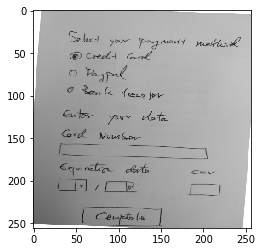

In [6]:
image = get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png')
plt.imshow(image);

***

## Create a Vocabulary

In [26]:
from string import printable

vocabulary = sorted(set(printable))
vocabulary.append('<START>')
vocabulary.append('<END>')

In [27]:
len(vocabulary)

102

### Word2Idx, Idx2Word maps

In [28]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [29]:
word2idx

{'\t': 0,
 '\n': 1,
 '\x0b': 2,
 '\x0c': 3,
 '\r': 4,
 ' ': 5,
 '!': 6,
 '"': 7,
 '#': 8,
 '$': 9,
 '%': 10,
 '&': 11,
 "'": 12,
 '(': 13,
 ')': 14,
 '*': 15,
 '+': 16,
 ',': 17,
 '-': 18,
 '.': 19,
 '/': 20,
 '0': 21,
 '1': 22,
 '2': 23,
 '3': 24,
 '4': 25,
 '5': 26,
 '6': 27,
 '7': 28,
 '8': 29,
 '9': 30,
 ':': 31,
 ';': 32,
 '<': 33,
 '=': 34,
 '>': 35,
 '?': 36,
 '@': 37,
 'A': 38,
 'B': 39,
 'C': 40,
 'D': 41,
 'E': 42,
 'F': 43,
 'G': 44,
 'H': 45,
 'I': 46,
 'J': 47,
 'K': 48,
 'L': 49,
 'M': 50,
 'N': 51,
 'O': 52,
 'P': 53,
 'Q': 54,
 'R': 55,
 'S': 56,
 'T': 57,
 'U': 58,
 'V': 59,
 'W': 60,
 'X': 61,
 'Y': 62,
 'Z': 63,
 '[': 64,
 '\\': 65,
 ']': 66,
 '^': 67,
 '_': 68,
 '`': 69,
 'a': 70,
 'b': 71,
 'c': 72,
 'd': 73,
 'e': 74,
 'f': 75,
 'g': 76,
 'h': 77,
 'i': 78,
 'j': 79,
 'k': 80,
 'l': 81,
 'm': 82,
 'n': 83,
 'o': 84,
 'p': 85,
 'q': 86,
 'r': 87,
 's': 88,
 't': 89,
 'u': 90,
 'v': 91,
 'w': 92,
 'x': 93,
 'y': 94,
 'z': 95,
 '{': 96,
 '|': 97,
 '}': 98,
 '~': 99,


***

## Max DSL Code Length

In [30]:
print('Total number of examples: {}'.format(len(sketch_id_code_map.values())))

Total number of examples: 58


In [31]:
longets_code = max(
    sketch_id_code_map.values(), key=lambda x: len(x))

print('Longes code:')
print('=' * 30)
print()
print(longets_code)

Longes code:

<!DOCTYPE html>
<html lang="en">
<head>
  <meta name="generator" content="HTML Tidy for HTML5 for Apple macOS version 5.6.0">
  <meta name="viewport" content="width=device-width">
  <title>HTML Result</title>
  <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity=
  "sha384-WskhaSGFgHYWDcbwN70/dfYBj47jz9qbsMId/iRN3ewGhXQFZCSftd1LZCfmhktB" crossorigin="anonymous">
</head>
<body>
  <div class="container body-content">
    <div class="container">
      <div class="row justify-content-start" style="padding-top:10px;">
        <div class="col" style="padding-top:10px;">
          <div class="row justify-content-start" style="padding-top:10px;">
            <h1>TITLE</h1>
          </div>
          <div class="row justify-content-start" style="padding-top:10px;">
            <label>Title Page</label>
          </div>
        </div>
        <div class="col" style="padding-top:10px;"><img alt="Image html" width="90%" hei

In [32]:
max_code_length = len(longets_code) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 4996


***

## Train/Dev/Test split

In [42]:
len(sketch_id_code_map)

58

In [43]:
SPLIT = (1., .0, .0)

In [44]:
items = list(sketch_id_code_map.items())
total_num = len(items)

borders = (
    int(total_num * SPLIT[0]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]) + int(
        total_num * SPLIT[2]),
)

train_sketch_id_code_map = dict(items[0:borders[0]])
dev_sketch_id_code_map = dict(items[borders[0]:borders[1]])
test_sketch_id_code_map = dict(items[borders[1]:borders[2]])

In [45]:
assert len(train_sketch_id_code_map) + len(dev_sketch_id_code_map) + len(
    test_sketch_id_code_map) == len(sketch_id_code_map)

In [46]:
print('Train Set size: {}'.format(len(train_sketch_id_code_map)))
print('Dev Set size: {}'.format(len(dev_sketch_id_code_map)))
print('Test Set size: {}'.format(len(test_sketch_id_code_map)))

Train Set size: 58
Dev Set size: 0
Test Set size: 0


***

In [47]:
EMBEDDING_DIM = 128
NUM_HIDDEN_NEURONS = [256, 256]

# Sketch Encoder (ConvNet)

In [48]:
sketch_encoder = SketchEncoder(EMBEDDING_DIM).build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [49]:
plot_model(sketch_encoder.model, to_file='./plots/sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv_32_1 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_dropout_1 (Dropout)     (None, 126, 126, 32)      0         
_________________________________________________________________
conv_64_1 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv_64_2 (Conv2D)           (None, 122, 122, 64)      36928     
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../../img/LSTM.png)

In [50]:
sequence_decoder = SequenceDecoder(max_code_length, EMBEDDING_DIM, len(vocabulary), NUM_HIDDEN_NEURONS).build_model()

In [51]:
plot_model(sequence_decoder.model, to_file='./plots/sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 4996)         0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 4996, 128)    13056       sequence_input[0][0]             
__________________________________________________________________________________________________
sketch_embedding_input (InputLa (None, 1, 128)       0                                            
__________________________________________________________________________________________________
lstm_decoder_1 (LSTM)           multiple             394240      sketch_embedding_input[0][0]     
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NSC_model](../../img/NSC.png)

In [52]:
neural_sketch_coding = NeuralSketchCoding(
    EMBEDDING_DIM, max_code_length, len(vocabulary), NUM_HIDDEN_NEURONS).build_model()

In [53]:
plot_model(neural_sketch_coding.model, to_file='./plots/neural_sketch_coding.png', show_shapes=True, show_layer_names=True)

print(neural_sketch_coding.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 4996)         0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 1, 128)       104229280   image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 4996, 102)    958822      sequence_input[0][0]             
                                                                 sketch_encoder[1][0]             
Total para

***

# Inference

![LSTM_sampling](../../img/Sampling.png)

In [54]:
inference = NSCInference(neural_sketch_coding, word2idx)

In [56]:
inference.greedy_search(
    get_preprocessed_img(PATH_TO_DATA+demo_sketch_id+'.png')
)

***

## Run Train

### Callbacks

In [28]:
filepath="weights/nsc-weights.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    if epoch % 5 == 0:
        print()
        print('Sampled:')
        print('='*30)
        print(greedy_search_inference(get_preprocessed_img(
            PATH_TO_DATA+np.random.choice(list(dev_sketch_id_code_map.keys()))+'.png'
        )))
        print()
        print()

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [107]:
neural_sketch_coding.model.load_weights('../weights/nsc-weights.hdf5')

neural_sketch_coding.model.compile(RMSprop(0.0001), loss='categorical_crossentropy')

In [110]:
batch_size = 64
steps = len(train_sketch_id_code_map) // batch_size

neural_sketch_coding.model.fit_generator(
    data_generator(train_sketch_id_code_map, word2idx, batch_size, max_code_length, len(vocabulary)),
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

***

## Dev

In [111]:
from nltk.translate import bleu_score

inference = NSCInference(neural_sketch_coding, word2idx)

In [112]:
def evaluate(path_to_img=None, reference=None):
    if path_to_img is None:
        sketch_id = np.random.choice(list(dev_sketch_id_code_map.keys()))
        sketch = get_preprocessed_img(PATH_TO_DATA+sketch_id+'.png')
        reference = [dev_sketch_id_code_map[sketch_id]]
        
    else:
        sketch = get_preprocessed_img(path_to_img)

    hypothesis = inference.greedy_search(sketch)
    
    print('Greedy Search Hypothesis:')
    print('='*30)
    print()
    print(hypothesis)
    print(end='\n\n')
    
    print('Reference:')
    print('='*30)
    print()
    print(reference[0])
    print(end='\n\n')
    
    print('BLEU score: {}'.format(
        bleu_score.sentence_bleu(reference, hypothesis)
    ))
        
    plt.imshow(sketch);

Greedy Search Hypothesis:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



Reference:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



BLEU score: 1.0


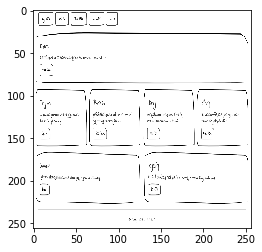

In [113]:
evaluate()

***

# Compilation

In [114]:
from src.compilers import web

In [116]:
sketch = get_preprocessed_img('./test.png')

dsl_code = inference.greedy_search(sketch)
with open('./dsl_code.gui', 'w') as f:
    f.write(dsl_code)

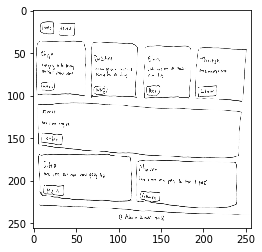

In [117]:
plt.imshow(sketch);

In [118]:
web_compiler = web.Compiler(dsl_mapping_file_path='../compilers/web/dsl_mapping.json')
web_compiler.compile('./dsl_code.gui', './out.html')